## Libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
import json
import numpy as np
from typing import List, Dict, Any
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from scripts.Tools import read_dialogue, get_conversation_by_id 

## Data

In [3]:
dataset = "Books"

In [4]:
with open(f"../data/{dataset}/item_map.json", "r") as f:
    item_map = json.load(f)

with open(f"../data/{dataset}/final_data.jsonl", "r") as f:
    final_data = [json.loads(line) for line in f]

dialogues = read_dialogue(f"../data/{dataset}/Conversation.txt")

In [5]:
items = list(set([item_map[key].lower().strip() for key in item_map]))

In [6]:
item_interactions = {}
for user_data in final_data:
    for user_id in user_data:
        for item_id in user_data[user_id]["history_interaction"]:
            item_name = item_map[item_id].lower().strip()
            if item_name not in item_interactions:
                item_interactions[item_name] = 0
            item_interactions[item_name] += 1

In [7]:
def get_messages(conversation_id: int, dialogues: str) -> List[BaseMessage]:

    conversation = get_conversation_by_id(dialogues, conversation_id)
    lines = conversation.strip().split("\n\n")
    messages = []

    for line in lines:
        if line.startswith("User:"):
            messages.append(HumanMessage(content=line[5:].strip()))
        elif line.startswith("Agent:"):
            messages.append(AIMessage(content=line[6:].strip()))
    
    return messages

## Models 1

In the following subsection, we implement three baseline models for conversational recommendation:

1. Random recommendation
2. Most popular recommendation
3. Zero-shot recommendation


In [8]:
def recommend_random(items: List[str], n: int = 5):
    return np.random.choice(items, n, replace=False).tolist()


def recommend_most_popular(item_interactions: Dict[str, int], n: int = 5):
    most_popular_items = sorted(
        item_interactions, key=item_interactions.get, reverse=True
    )[:n]
    return most_popular_items


def recommend_zero_shot(messages: List[BaseMessage], n: int = 5, verbose: bool = False):

    class Recommendation(BaseModel):
        items: Any = Field(
            description="A list of items. Each item must contain a 'reason' and a 'name'"
        )

    system = """
        You are a recommender system.
        Recommend {n} items based on the user's conversation.
        Sort the items by descending order of relevance.

        Conversation:
        {messages}
        """

    prompt = ChatPromptTemplate.from_messages([("system", system)])

    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    structured_llm = llm.with_structured_output(Recommendation, include_raw=True)

    zero_shot_structured_llm = prompt | structured_llm
    response = zero_shot_structured_llm.invoke({"messages": messages, "n": n})

    prompt_tokens = response["raw"].response_metadata["token_usage"]["prompt_tokens"]
    completion_tokens = response["raw"].response_metadata["token_usage"][
        "completion_tokens"
    ]

    cost = 0.150 * prompt_tokens / 1000000 + 0.600 * completion_tokens / 1000000

    if verbose:
        print(f"Prompt Tokens: {prompt_tokens}")
        print(f"Completion Tokens: {completion_tokens}")
        print(f"Cost: ${cost} USD")

    return response["parsed"].items

In [9]:
recommend_random(items)

['the pencil: a history of design and circumstance',
 'new drawing on the right side of the brain workbook',
 'apache legacy (lovegram historical romance)',
 'deadly pursuit: a novel (guardians of justice) (volume 2)',
 'starseers (fallen empire) (volume 3)']

In [10]:
recommend_most_popular(item_interactions)

['gone girl',
 'the girl on the train',
 'the pillars of the earth',
 'the old man and the sea',
 'books" />']

In [11]:
messages = get_messages(0, dialogues)
recommend_zero_shot(messages[:1], n=3, verbose=False)

[{'name': 'The Perfect Ruin by Shanora Williams',
  'reason': "This book is filled with drama and suspense, similar to 'We Both Can't Be Bae'. It involves a story of revenge and secrets that will keep you on the edge of your seat."},
 {'name': 'The Coldest Winter Ever by Sister Souljah',
  'reason': "This novel is a classic in urban fiction, known for its intense drama and captivating storyline, much like 'We Both Can't Be Bae'."},
 {'name': 'Addicted by Zane',
  'reason': "This book offers a mix of drama and romance, with a gripping plot that will appeal to fans of 'We Both Can't Be Bae'."}]

## Models 2

In the following subsection, we implement the first agent.

In order to run this section, add the following variables to your .env: OPENAI_API_KEY and TAVILY_API_KEY.

### Vector database

The most important tool is the vector database, as it allows to interact semantically with the currrent catalog of books.

In [12]:
import tiktoken
from uuid import uuid4
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

In [13]:
def get_token_count(text: str) -> int:
    model = "text-embedding-3-small"
    encoding_name = tiktoken.encoding_for_model(model).name
    encoding = tiktoken.get_encoding(encoding_name)
    total_tokens = len(encoding.encode(text))

    return total_tokens

def get_embedding_cost(num_tokens: int) -> float:
    cost_per_million_tokens = 0.020
    return cost_per_million_tokens * (num_tokens / 1_000_000)

In [14]:
documents = []
for item in items:
    if item != "":
        documents.append(Document(page_content=f"Book: {item}"))

In [15]:
documents[:5]

[Document(metadata={}, page_content='Book: the road to deer run'),
 Document(metadata={}, page_content='Book: late for tea at the deer palace: the lost dreams of my iraqi family'),
 Document(metadata={}, page_content='Book: sinful scottish laird: a historical romance novel (the highland grooms)'),
 Document(metadata={}, page_content='Book: wolf creek enforcer: texas pack (volume 2)'),
 Document(metadata={}, page_content="Book: the wizard's dilemma: the fifth book in the young wizards series")]

In [16]:
total_tokens = 0
expected_cost = 0
for doc in documents:
    tokens = get_token_count(doc.page_content)
    total_tokens += tokens
    expected_cost += get_embedding_cost(tokens)
print(f"Total tokens: {total_tokens}")
print(f"Expected cost: {expected_cost}")

Total tokens: 2150836
Expected cost: 0.04301671999999592


In [17]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

store = Chroma(
    collection_name="books",
    embedding_function=embeddings,
    persist_directory="../store",
)

In [18]:
# NOTE: Only run this once
#uuids = [str(uuid4()) for _ in documents]
# Iterate in batches of 10,000
#for i in range(0, len(documents), 10_000):
#    print(f"Adding documents {i} to {i + 10_000}")
#    store.add_documents(documents=documents[i : i + 10_000], ids=uuids[i : i + 10_000])

### Agent

In [19]:
from typing import Annotated, Sequence, Optional
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableLambda
from langchain_community.tools import TavilySearchResults

In [20]:
tavily_tool = TavilySearchResults(
    max_results=10,
    search_depth="advanced",
    include_answer=False,
    include_raw_content=False,
    include_images=False,
    description="Search the web for information about books.",
    )

books_retriever = create_retriever_tool(
    store.as_retriever(search_type="similarity", search_kwargs={"k": 10}),
    "retrieve_books",
    "Search and return books in the database.",
)

In [21]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


async def agent(state):

    messages = state["messages"]

    prompt = PromptTemplate.from_template(
        template="""
            You are a conversational recommender system specialized in books.
            Given a current conversation, recommend 3 books that align with the user's interests.

            Current conversation is as follows:
            {messages}
        """
    )

    llm = ChatOpenAI(
        temperature=0,
        streaming=True,
        model="gpt-4o",
        model_kwargs={"stream_options": {"include_usage": True}},
    )

    tools = [books_retriever, tavily_tool]

    llm = llm.bind_tools(tools)

    chain = prompt | llm

    response = await chain.ainvoke({"messages": messages})

    return {"messages": [response]}

def should_continue(state):

    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "tools"

In [22]:
workflow = StateGraph(AgentState)
tools = ToolNode([books_retriever, tavily_tool])

workflow.add_node("agent", RunnableLambda(agent))
workflow.add_node("tools", tools)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent", should_continue, {END: END, "tools": "tools"})
workflow.add_edge("tools", "agent")

workflow.add_edge("agent", END)

# Compile
graph = workflow.compile()

In [23]:
def get_inference_cost(messages: list[BaseMessage]) -> float:
    input_tokens = 0
    output_tokens = 0

    for message in messages:
        if isinstance(message, AIMessage):
            input_tokens += message.usage_metadata["input_tokens"]
            output_tokens += message.usage_metadata["output_tokens"]
    return input_tokens * 0.150 / 1_000_000 + output_tokens * 0.0600 / 1_000_000

In [24]:
async def recommend_graph(graph, messages: list[BaseMessage], show_cost: bool = False) -> list[BaseMessage]:
    
    state = {"messages": messages}
    output = await graph.ainvoke(state)

    if show_cost:
        cost = get_inference_cost(output["messages"])
        print(f"Cost: ${cost} USD")
        
    return output["messages"]

In [25]:
messages = get_messages(0, dialogues)

In [26]:
await recommend_graph(graph, messages[:1], show_cost=True)

Cost: $0.00086493 USD


[HumanMessage(content='Hello! I recently read "We Both Can\'t Be Bae (Volume 1)" and I really enjoyed it. The drama in the story kept me hooked. Can you recommend another book similar to it?', additional_kwargs={}, response_metadata={}, id='ac0d96f1-2394-4253-9af7-4492de4ea5d6'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_8lvbmJqjaORGHK4mDq2srCKL', 'function': {'arguments': '{"query": "We Both Can\'t Be Bae (Volume 1) similar books"}', 'name': 'retrieve_books'}, 'type': 'function'}, {'index': 1, 'id': 'call_nSaqkf30CpmaWpudpYZmnrLl', 'function': {'arguments': '{"query": "books similar to We Both Can\'t Be Bae (Volume 1)"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc'}, id='run-776c29d8-edd9-4543-adbc-016bc19668f7-0', tool_calls=[{'name': 'retrieve_books', 'args': {'query': "We Both Can't Be Bae (Volume 1) sim

### Multi agent

Here we implement our first Multi Agent system. The first agent is specialized in searching data from the internet while the second one takes the role of a librarian to "map" all the searched data to books in the current catalog.

In [27]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [28]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [29]:
import functools

from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the librarian_agent to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="research_node")

librarian_agent = create_agent(
    llm,
    [books_retriever],
    system_message="You are a conversational recommender system specialized in books. Recommend 3 books that align with the user's interests.",
)

librarian_node = functools.partial(agent_node, agent=librarian_agent, name="librarian_node")

In [30]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, books_retriever]
tool_node = ToolNode(tools)

In [31]:
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

In [32]:
workflow = StateGraph(AgentState)

workflow.add_node("research_node", research_node)
workflow.add_node("librarian_node", librarian_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "research_node",
    router,
    {"continue": "librarian_node", "call_tool": "call_tool", END: END},
)
workflow.add_conditional_edges(
    "librarian_node",
    router,
    {"continue": "research_node", "call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "research_node": "research_node",
        "librarian_node": "librarian_node",
    },
)
workflow.add_edge(START, "research_node")
graph = workflow.compile()

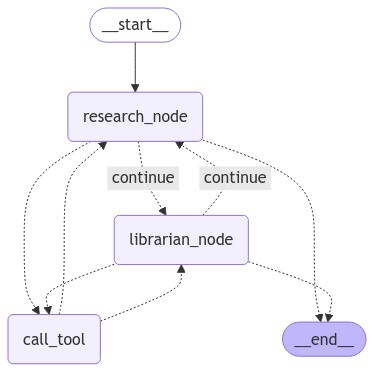

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
messages = get_messages(0, dialogues)

In [35]:
await recommend_graph(graph, messages[0:1], show_cost=True) # Pass only the first message

Cost: $0.0017770499999999999 USD


[HumanMessage(content='Hello! I recently read "We Both Can\'t Be Bae (Volume 1)" and I really enjoyed it. The drama in the story kept me hooked. Can you recommend another book similar to it?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r541umlKxmXj1jRuOUtE9sAa', 'function': {'arguments': '{"query":"books similar to We Both Can\'t Be Bae Volume 1"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 207, 'total_tokens': 236, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, name='research_node', id='run-2e405717-1fb9-4300-93f2-d0a0473123